<a href="https://colab.research.google.com/github/xli2522/BBH-merger-waveform-data-release/blob/main/BBH-merger-for-NN-training/z-axis-spin/BBH_waveform_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  
#  BBH Merger Gravitational Wave Waveform with Noise 
#####(for GW Classifier Training) 
##### © Xiyuan Li 2022, Department of Physics and Astronomy, Western University (University of Western Ontario), London, Ontario, Canada
##### Resources: 
[PyCBC](http://github.com/ligo-cbc/pycbc) + additional PyCBC [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html).

In [1]:
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'

     |████████████████████████████████| 27.3 MB 1.9 MB/s 
     |████████████████████████████████| 6.3 MB 26.1 MB/s 
     |████████████████████████████████| 1.4 MB 34.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 5.9 MB/s 
     |████████████████████████████████| 78 kB 5.8 MB/s 
     |████████████████████████████████| 45 kB 1.3 MB/s 
     |████████████████████████████████| 14.8 MB 40.7 MB/s 
     |████████████████████████████████| 201 kB 31.9 MB/s 
     |████████████████████████████████| 295 kB 23.6 MB/s 
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 4.1 MB 18.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.

In [2]:
import pycbc
import pylab
from pycbc.catalog import Merger
from pycbc.waveform import get_td_waveform
from pycbc.filter import resample_to_delta_t, highpass
import pycbc.noise
import pycbc.psd

import numpy as np
import pandas as pd
import time

import sys
import random
import matplotlib.pyplot as plt
import h5py

#### Utility Functions

In [3]:
def unisonShuffle(a, b):
    '''Random shuffle two arrays in the same order.'''
    rng_state = np.random.get_state()
    permu_a = np.random.shuffle(a)
    np.random.set_state(rng_state)
    permu_b = np.random.shuffle(b)

    return permu_a, permu_b

In [4]:
# merger frequency estimation related
def f_merger(m1, m2):
    '''Merger frequency estimation'''
    Mchirp = (m1*m2)**(3/5)/(m1+m2)**(1/5)
    c = 3*10**8           # speed of light
    G = 6.674*10**(-11)   # gravitational constant
    R = 1.7               # compactness ratio

    # merger frequency formula
    freq = (c**3)/(R**(3/2)*2**(3/2)*G*Mchirp*1.989*10**30)/(np.pi)     

    return freq

def f_evolution(m1, m2, t):
    '''Frequency evolution estimation'''
    ts = np.linspace(1, t, t*100)             # trace back t before the merger, 
                                              # up to 100th a second
    tc = t                                    
    tau = tc - ts
    Mchirp = (m1*m2)**(3/5)/(m1+m2)**(1/5) 
    c = 3*10**8           # speed of light
    G = 6.674*10**(-11)   # gravitational constant
    freq_gw = (1/np.pi)*((5/(256*tau))**(3/8))*((G*Mchirp*1.989*10**30)/c**3)**(-5/8)

    return freq_gw

def f_prior(m1, m2, tau):
    '''Frequency estimation, tau prior to the merger '''
    Mchirp = (m1*m2)**(3/5)/(m1+m2)**(1/5) 
    c = 3*10**8           # speed of light
    G = 6.674*10**(-11)   # gravitational constant
    freq_prior = (1/np.pi)*((5/(256*tau))**(3/8))*((G*Mchirp*1.989*10**30)/c**3)**(-5/8)

    return freq_prior

def signaltonoise(Arr, axis=0, ddof=0):
    Arr = np.asanyarray(Arr)
    me = Arr.mean(axis)
    sd = Arr.std(axis=axis, ddof=ddof)
    
    return np.where(sd == 0, 0, me/sd)


In [5]:
# prepare progress bar
%%capture
from tqdm import tqdm as tqdm
tqdm().pandas()

#### Noise and Waveform Generation

In [6]:
def generate_Mass_pairs(lower_m = 1, higher_m = 45, dense = 100, 
                                                display=True, seed=None):
    '''
    Input:  
                  lower_m                     lower mass limit 
                  higher_m                    higher mass limit 
                  dense                       mass density
                  display (optional)           
                  seed (optional)
    Output:
                  training_m1, training_m2, 
                            testing_m1, testing_m2, 
                                      validation_m1, validation_m2            
    '''
    sum_m1 = np.ones(1); sum_m2 = np.ones(1)  

    for m1 in np.linspace(lower_m, higher_m, dense): 
        rounded_m1 = float("{0:.3f}".format(m1))          # round to 3 sig figs
        
        m2_dense = int(m1/higher_m*dense)                # ratioed m2 density
        #m2_dense = dense                           # even m2 density (number)
        
        sum_m1 = np.concatenate((sum_m1, np.full(m2_dense, rounded_m1)), axis=0)
        sum_m2 = np.concatenate((sum_m2, np.around(np.linspace(lower_m, 
                                                      rounded_m1, m2_dense), 
                                                          decimals=3)), axis=0)
    sum_m1 = np.delete(sum_m1, 0); sum_m2 = np.delete(sum_m2, 0)
    print('Total Number of Mass Pairs: '+ str(len(sum_m1)))
    unisonShuffle(sum_m1, sum_m2)                         # shuffle mass pairs
    
    # Segement training, testing, and validation sets
    # split ratio: 70:15:15
    N = len(sum_m1)                                       # total # of pairs
    training_m1 = sum_m1[int(N*0.3):]; training_m2 = sum_m2[int(N*0.3):]
    testing_m1 = sum_m1[:int(N*0.15)]; testing_m2 = sum_m2[:int(N*0.15)]
    validation_m1 = sum_m1[int(N*0.15):int(N*0.30)]
    validation_m2 = sum_m2[int(N*0.15):int(N*0.30)]

    print('# of Traning masses ' + str(len(training_m1)))
    print('# of Testing masses ' + str(len(testing_m1)))
    print('# of Validation masses ' + str(len(validation_m1)))

    #Plot Training and Testing Masses
    if display:
        plt.figure()
        plt.scatter(training_m1, training_m2, c='b',s=5)
        plt.scatter(testing_m1, testing_m2, c ='r', s=5)
        plt.scatter(validation_m1, validation_m2, c ='g', s=5)
        plt.xlabel(r'$m_1$')
        plt.ylabel(r'$m_2$')
        plt.legend(['Training', 'Testing', 'Validation'])
        plt.title('Testing, Training, and Validation Masses')
        plt.show()
        
    return training_m1, training_m2, testing_m1, testing_m2, \
                                                  validation_m1, validation_m2

In [7]:
# specify the sample rate
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# signal frequency f_Nyquist = 8192 Hz.

sample_rate = 2048        # samples per second
data_length = 6           # seconds

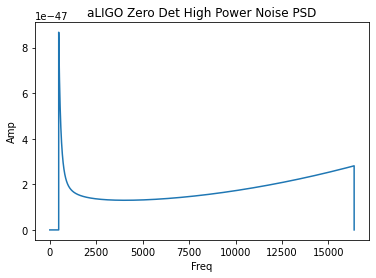

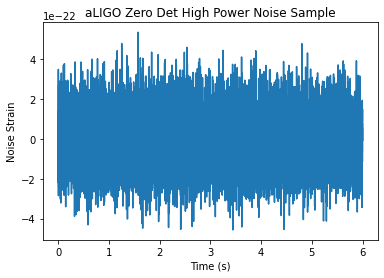

In [8]:
# colored LIGO noise
flow = 30.0
delta_f = 1.0 / 16
flen = int(sample_rate / (2*delta_f)) + 1        # -> upper frequency 1024 Hz
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# inspect LIGO Zero Detuned High Power Noise
plt.plot(psd)
plt.ylabel('Amp')
plt.xlabel('Freq')
plt.title('aLIGO Zero Det High Power Noise PSD')
plt.show()

delta_t = 1.0 / sample_rate        
tsamples = int(data_length / delta_t)
aLIGO_noise = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=10)

plt.plot(aLIGO_noise.sample_times, aLIGO_noise)
plt.ylabel('Noise Strain')
plt.xlabel('Time (s)')
plt.title('aLIGO Zero Det High Power Noise Sample')
plt.show()

In [9]:
# merger waveform generation 
apx = 'IMRPhenomD'                                        # the "approximant"

start_time = time.time()
# You can specify many parameters, 
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform

def generate_merger_waveform(array_m1, array_m2, sample_rate, duration, 
                                  distance, merger_time, spin=0.8, 
                                    inclination=0, noise=True, savefile=True, 
                                                                filename=None):
    '''
    Dataframe Parameters:
                  'Waveform',                         
                  'm1', 
                  'm2', 
                  'Merger Position',        
                          0: merger near the end of the specified duration
                          1: merger near the center of the specified duration
                          2: merger near the beginning of the specified duration
                  'spin1z', 'spin2z',               BH spin in z
                  'Distance',                       luminosity distance in Mpc
                  'PSNAR'                           peak signal-noise amplitude
    '''
    training_series = pd.DataFrame(columns=['Waveform', 
                                            'm1', 'm2', 'Merger Position', 
                                            'spin1z', 'spin2z', 'Distance', 
                                                                    'PSNAR'])
    N = len(array_m1)                                  # total # of pairs
    if noise:
        # colored LIGO noise
        flow = 30.0
        delta_f = 1.0 / 16
        flen = int(sample_rate / (2 * delta_f)) + 1    # upper frequency 1024 Hz
        psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
        delta_t = 1.0 / sample_rate        
    
    rounded_z_spin1 = np.around(np.random.random(N)*2*spin-spin, decimals=3, out=None)
    rounded_z_spin2 = np.around(np.random.random(N)*2*spin-spin, decimals=3, out=None)
    waveform_exception = []
    
    with tqdm(total=N) as pbar:
        for i in range(N):
            # estimated frequency at 'duration' seconds before the merger
            lower_Freq = f_prior(array_m1[i], array_m2[i], duration)       
            try:
                hp1, _ = get_td_waveform(approximant=apx,
                                    mass1=array_m1[i],
                                    mass2=array_m2[i],
                                    delta_t=1.0/sample_rate,
                                    f_lower=lower_Freq,
                                    spin1z = rounded_z_spin1[i],
                                    spin2z = rounded_z_spin2[i],
                                    distance = distance)
            except:
                # set spin to 0
                hp1, _ = get_td_waveform(approximant=apx,
                                    mass1=array_m1[i],
                                    mass2=array_m2[i],
                                    delta_t=1.0/sample_rate,
                                    f_lower=lower_Freq,
                                    spin1z = 0,
                                    spin2z = 0,
                                    distance = distance)
            # finally:
            #     print('get_td_waveform process interupted at # '+ str(i))
            #     waveform_exception.append([array_m1[i], array_m2[i], 
            #                           rounded_z_spin1[i], rounded_z_spin2[i], 
            #                                                           distance])
            hp1 = np.asarray(hp1)
            # trim hp1 size - translate to a new function
            trim_mergerWaveform(hp1, merger_time[i], duration)

            snr = None;   peak_amp_ratio = None   
            if noise:
                tsamples = len(hp1)
                noise_signal = pycbc.noise.noise_from_psd(tsamples, delta_t, psd)
                
                hp1_noisy = hp1 + noise_signal   
                # will add signal to noise ratio calculation

                peak_amp_ratio = max(hp1)/max(noise_signal)
                hp1 = np.asarray(hp1_noisy)
            
            training_series.loc[i] = [hp1 , array_m1[i] , 
                            array_m2[i] , merger_time[i], rounded_z_spin1[i], 
                                rounded_z_spin2[i], distance , peak_amp_ratio]
        

            pbar.update(1)

    print("--- %s seconds ---" % (time.time() - start_time))
    print('Generated '+str(len(training_series))+' training times series.')
    print('Final dataframe size in memory: '+ str(sys.getsizeof(training_series)/10**6) + 'Mb.')

    if savefile:
        unique_stamp = time.time()
        training_series.to_csv(str(filename) + str(unique_stamp) +'waveform_data.csv',  mode='w')

    return training_series, waveform_exception

In [10]:
def trim_mergerWaveform(hp1, merger_time, duration):
    '''
    merger_time        
                          0: merger near the end of the specified duration
                          1: merger near the center of the specified duration
                          2: merger near the beginning of the specified duration
    '''
    hp1_length = len(hp1)
    if merger_time == 0:         # no shift
        if hp1_length<duration*sample_rate:
            hp1 = np.hstack((
                    np.zeros(duration*sample_rate-len(hp1)+100), hp1))
        hp1 = hp1[hp1_length-duration*sample_rate:]

    elif merger_time == 1:       # center shift
        # position of the waveform peak in the array
        merger_position = np.argmax(hp1)              
        hp1 = np.hstack((np.zeros(duration*sample_rate), hp1, 
                                            np.zeros(duration*sample_rate)))
        reference = int(merger_position+duration*sample_rate//2       \
                        +np.random.randint(-int(duration/10*sample_rate), 
                                                int(duration/10*sample_rate)))
        hp1 = hp1[reference:int(reference+duration*sample_rate)]    # check size
        
    elif merger_time == 2:       # beginning shift
        # position of the waveform peak in the array
        merger_position = np.argmax(hp1)              
        hp1 = np.hstack((np.zeros(duration*sample_rate), hp1, 
                                            np.zeros(duration*sample_rate)))
        reference = int(merger_position+3*duration/4*sample_rate      \
                        +np.random.randint(-int(duration/10*sample_rate), 
                                                int(duration/10*sample_rate)))
        hp1 = hp1[reference:int(reference+duration*sample_rate)]    # check size

    return hp1

Total Number of Mass Pairs: 11320
# of Traning masses 7924
# of Testing masses 1698
# of Validation masses 1698


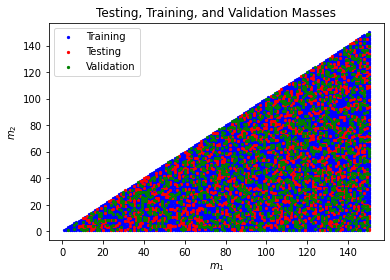

100%|██████████| 7924/7924 [14:06<00:00,  9.36it/s]


--- 847.0910818576813 seconds ---
Generated 7924 training times series.
Final dataframe size in memory: 2275.501356Mb.


100%|██████████| 1698/1698 [02:57<00:00,  9.58it/s]


--- 1025.6928956508636 seconds ---
Generated 1698 training times series.
Final dataframe size in memory: 491.747908Mb.


100%|██████████| 1698/1698 [02:56<00:00,  9.60it/s]


--- 1202.8368141651154 seconds ---
Generated 1698 training times series.
Final dataframe size in memory: 495.843864Mb.
Total Number of Mass Pairs: 11320
# of Traning masses 7924
# of Testing masses 1698
# of Validation masses 1698


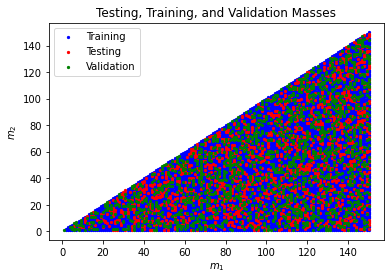

100%|██████████| 7924/7924 [13:50<00:00,  9.55it/s]


--- 2033.6482591629028 seconds ---
Generated 7924 training times series.
Final dataframe size in memory: 2285.987012Mb.


100%|██████████| 1698/1698 [02:57<00:00,  9.54it/s]


--- 2212.9519374370575 seconds ---
Generated 1698 training times series.
Final dataframe size in memory: 488.634872Mb.


100%|██████████| 1698/1698 [02:57<00:00,  9.55it/s]


--- 2391.173859834671 seconds ---
Generated 1698 training times series.
Final dataframe size in memory: 495.843964Mb.
Total Number of Mass Pairs: 11320
# of Traning masses 7924
# of Testing masses 1698
# of Validation masses 1698


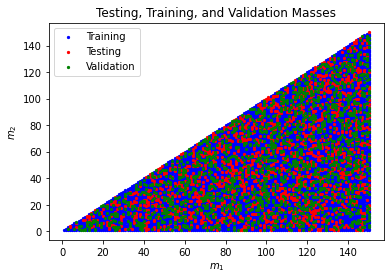

100%|██████████| 7924/7924 [13:56<00:00,  9.47it/s]


--- 3228.570054292679 seconds ---
Generated 7924 training times series.
Final dataframe size in memory: 2276.77904Mb.


100%|██████████| 1698/1698 [03:01<00:00,  9.38it/s]


--- 3411.0386011600494 seconds ---
Generated 1698 training times series.
Final dataframe size in memory: 492.272076Mb.


100%|██████████| 1698/1698 [03:01<00:00,  9.36it/s]


--- 3592.776632785797 seconds ---
Generated 1698 training times series.
Final dataframe size in memory: 505.8052Mb.


In [11]:
for distance in [410, 610, 810]:
                
    training_m1, training_m2, testing_m1, testing_m2, validation_m1, validation_m2 = generate_Mass_pairs(lower_m=1, higher_m=150, dense=150)
    merger_position = np.random.randint(3, size=len(training_m1))
    training, skipped_1 = generate_merger_waveform(training_m1, training_m2, sample_rate, 6, distance, merger_time=merger_position, noise=True, filename='training-6s-merger-wnoise-'+str(distance)+'Mpc')
    
    merger_position = np.random.randint(3, size=len(testing_m1))
    testing, skipped_2 = generate_merger_waveform(testing_m1, testing_m2, sample_rate, 6, distance, merger_time=merger_position, noise=True,filename='testing-6s-merger-wnoise-'+str(distance)+'Mpc')
    
    merger_position = np.random.randint(3, size=len(validation_m1))
    validation, skipped_3 = generate_merger_waveform(validation_m1, validation_m1, sample_rate, 6, distance, merger_time=merger_position, noise=True,filename='validation-6s-merger-wnoise-'+str(distance)+'Mpc')